# NHL Fight Data Analysis

### In this notebook, we have analyzed the relationship between game outcomes like goal scoring, puck possession, unblocked shot attempts, match-winning, etc., with fights between players of different teams. 

### Further, we have also compared and performed a correlation analysis between teams' performance in the following two matches after they fought in their previous game to understand the psychological impact of a fistfight on the team.

#### Imported the required libraries

In [1]:
import numpy as np
import pandas as pd
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import figure
import warnings

warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 0)

#### Load fight data

In [3]:
fight = pd.read_csv('data/fight_table.csv')

In [4]:
fight['date_of_fight'] = pd.to_datetime(fight['date_of_fight'])
fight['digits'] = fight.apply(lambda row: re.findall("\d*\.*\d+", row['winner']), axis=1)
fight['Voted winner (%)'] = fight.apply(lambda row: row['digits'][0], axis=1)
fight['Voted rating'] = fight.apply(lambda row: row['digits'][1], axis=1)
del fight['digits']

In [5]:
fight.head(5)

,date_of_fight,idk_column,player1_name,player1_team,player2_name,player2_team,winner,Voted winner (%),Voted rating
0,2000-04-09,3 Pd 7:47,Dale Purinton,NYR,Keith Primeau,PHI,Voted winner: Keith Primeau (50%) - Voted rating: 4,50,4
1,2000-04-09,3 Pd 10:1,Andre Roy,OTT,Cory Sarich,TBL,Voted winner: Draw (50%) - Voted rating: 0,50,0
2,2000-04-09,1 Pd 6:13,Andre Roy,OTT,Kyle Freadrich,TBL,Voted winner: Kyle Freadrich (100%) - Voted rating: 5,100,5
3,2000-04-08,3 Pd 19:37,Clarke Wilm,CAL,Dan LaCouture,EDM,Voted winner: Draw (50%) - Voted rating: 0,50,0
4,2000-04-08,1 Pd 15:18,D.J. Smith,TOR,Gordie Dwyer,TBL,Voted winner: Gordie Dwyer (100%) - Voted rating: 10,100,10


In [6]:
fight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date_of_fight     10819 non-null  datetime64[ns]
 1   idk_column        10819 non-null  object        
 2   player1_name      10819 non-null  object        
 3   player1_team      10819 non-null  object        
 4   player2_name      10819 non-null  object        
 5   player2_team      10819 non-null  object        
 6   winner            10819 non-null  object        
 7   Voted winner (%)  10819 non-null  object        
 8   Voted rating      10819 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 760.8+ KB


####  Check if the teams are same in both ('player1_team' and 'player2_team') features.

In [7]:
display(fight['player1_team'].unique())
print('Count:', fight['player1_team'].unique().size)

display(fight['player2_team'].unique())
print('Count:', fight['player2_team'].unique().size)

array(['NYR', 'OTT', 'CAL', 'TOR', 'NSH', 'STL', 'MON', 'VAN', 'EDM',
       'TBL', 'FLA', 'ATL', 'PIT', 'NJD', 'COL', 'WAS', 'PHI', 'DET',
       'SJS', 'DAL', 'BUF', 'LAK', 'NYI', 'BOS', 'CHI', 'CAR', 'ARI',
       'ANA', 'MIN', 'CBJ', 'WPG', 'VGK', 'SEA'], dtype=object)

Count: 33


array(['PHI', 'TBL', 'EDM', 'COL', 'ANA', 'CHI', 'LAK', 'PIT', 'BOS',
       'NJD', 'NYI', 'ARI', 'DET', 'ATL', 'TOR', 'DAL', 'NYR', 'CAL',
       'MON', 'CAR', 'FLA', 'VAN', 'STL', 'BUF', 'WAS', 'OTT', 'SJS',
       'NSH', 'CBJ', 'MIN', 'WPG', 'VGK', 'SEA'], dtype=object)

Count: 33


In [8]:
intersection = pd.Series(list(set(fight['player1_team']).intersection(set(fight['player2_team']))))
display(intersection.count())

33

#### Since one dataset had full team names and other had abbreviations, we need to map the team names with it's abbreviations.

In [9]:
team_info = pd.read_json('data/teams_info.json')
team_name = [list(team_info.teams[idx].values())[1] for idx in range (team_info.shape[0])]
abbr = [list(team_info.teams[idx].values())[4] for idx in range (team_info.shape[0])]
mapping = {key:value for key, value in zip (abbr, team_name)}
mapping

{'NJD': 'New Jersey Devils',
 'NYI': 'New York Islanders',
 'NYR': 'New York Rangers',
 'PHI': 'Philadelphia Flyers',
 'PIT': 'Pittsburgh Penguins',
 'BOS': 'Boston Bruins',
 'BUF': 'Buffalo Sabres',
 'MTL': 'Montréal Canadiens',
 'OTT': 'Ottawa Senators',
 'TOR': 'Toronto Maple Leafs',
 'CAR': 'Carolina Hurricanes',
 'FLA': 'Florida Panthers',
 'TBL': 'Tampa Bay Lightning',
 'WSH': 'Washington Capitals',
 'CHI': 'Chicago Blackhawks',
 'DET': 'Detroit Red Wings',
 'NSH': 'Nashville Predators',
 'STL': 'St. Louis Blues',
 'CGY': 'Calgary Flames',
 'COL': 'Colorado Avalanche',
 'EDM': 'Edmonton Oilers',
 'VAN': 'Vancouver Canucks',
 'ANA': 'Anaheim Ducks',
 'DAL': 'Dallas Stars',
 'LAK': 'Los Angeles Kings',
 'SJS': 'San Jose Sharks',
 'CBJ': 'Columbus Blue Jackets',
 'MIN': 'Minnesota Wild',
 'WPG': 'Winnipeg Jets',
 'ARI': 'Arizona Coyotes',
 'VGK': 'Vegas Golden Knights',
 'SEA': 'Seattle Kraken'}

#### Extract the required data

In [10]:
fight = fight[(fight['date_of_fight'] >= '2015-01-01') & (fight['date_of_fight'] <= '2020-12-31')]
fight = fight.reset_index(drop=True)
player1_unique_count = fight['player1_team'].value_counts()   
player2_unique_count = fight['player2_team'].value_counts()   
index1 = list(player1_unique_count.index)
count1 = list(player1_unique_count.values)
index2 = list(player2_unique_count.index)
count2 = list(player2_unique_count.values)
fights = []
teams = []
for idx1, val1 in enumerate(index1):
    for idx2, val2 in enumerate(index2):
        if val1 == val2:
            fights.append(count1[idx1] + count2[idx2])
            teams.append(val1)

#### The amount of matches each team has played will vary according to the small number of teams that began competing in 2017 and 2018. As a result, we have normalized the teams data according to the number of season each team played from 2015 to 2020.

In [11]:
group = fight.groupby(by='player1_team')
active_years = (group['date_of_fight'].max() - group['date_of_fight'].min()).dt.days
active_years = active_years/365
active_years = active_years.apply(np.ceil)
list(active_years).sort()
active_years

player1_team
ANA    6.0
ARI    5.0
BOS    6.0
BUF    5.0
CAL    6.0
CAR    6.0
CBJ    6.0
CHI    6.0
COL    6.0
DAL    6.0
DET    5.0
EDM    6.0
FLA    6.0
LAK    6.0
MIN    6.0
MON    5.0
NJD    6.0
NSH    6.0
NYI    6.0
NYR    6.0
OTT    6.0
PHI    6.0
PIT    5.0
SJS    6.0
STL    6.0
TBL    6.0
TOR    6.0
VAN    6.0
VGK    3.0
WAS    6.0
WPG    6.0
Name: date_of_fight, dtype: float64

#### Obtain the teams with maximum fights per season and minimum fights per season

In [12]:
total_fights = {key:value for key, value in zip (teams, fights)}

for val in sorted(total_fights.keys()):
    total_fights[val] = total_fights[val] / active_years[val]
    
max_fight_val = np.amax(list(total_fights.values()))
min_fight_val = np.amin(list(total_fights.values()))
med = sorted(list(total_fights.values()))
median_fight_val = med[int((len(med) / 2 ) + 1)]

for key, value in total_fights.items():
    if max_fight_val == value:
        max_fight_team = key
    elif min_fight_val == value:
        min_fight_team = key
    elif median_fight_val == value:
        median_fight_team = key
median_team_val = 17

#### Load the statistical game outcome data

In [13]:
match = pd.read_csv('data/final_scrapped_data.csv')

#### Preprocessing of data (Data extraction and transformation)

In [14]:
selected_features = ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'Host_won', \
                     'home_CF%', 'guest_CF%', 'home_FF%', 'guest_FF%',  'home_HDCF%', 'guest_HDCF%', \
                     'home_HDGF%', 'guest_HDGF%', 'home_xGF_pp', 'guest_xGF_pp', 'home_PDO', \
                     'guest_PDO','home_Attendance', 
                     ]
match = match[selected_features].copy()

In [15]:
match = match.loc[match['date'] >= '2015-01-01'] 
match.reset_index(inplace = True, drop=True)

In [16]:
mapper = {
    'CGY' : 'CAL',
    'L.A' : 'LAK',
    'N.J' : 'NJD',
    'S.J' : 'SJS',
    'T.B' : 'TBL',
    'WSH' : 'WAS',
    'MTL' : 'MON'
}
for idx, val in enumerate(match['home_team']):
    if val in mapper.keys():
        match.loc[idx, 'home_team'] = mapper[val]
    else:
        pass
for idx, val in enumerate(match['away_team']):
    if val in mapper.keys():
        match.loc[idx, 'away_team'] = mapper[val]
    else:
        pass
match = match[match['home_team'] != 'AMERICAN ALL-STARS']
match = match[match['home_team'] != 'KHI']
match = match[match['away_team'] != 'AMERICAN ALL-STARS']
match = match[match['away_team'] != 'KHI']
match = match.reset_index(drop=True)

In [17]:
match['home_HDCF%'].replace('-', np.nan, inplace=True)
match['home_HDCF%'] = match['home_HDCF%'].astype('float64')
match['home_HDGF%'].replace('-', np.nan, inplace=True)
match['home_HDGF%'] = match['home_HDGF%'].astype('float64')

match['guest_HDCF%'].replace('-', np.nan, inplace=True)
match['guest_HDCF%'] = match['guest_HDCF%'].astype('float64')
match['guest_HDGF%'].replace('-', np.nan, inplace=True)
match['guest_HDGF%'] = match['guest_HDGF%'].astype('float64')

In [18]:
win = []
loss = []
for val in range(match.shape[0]):
    if match.loc[val, 'Host_won'] == 1:
        win.append(match.loc[val, 'home_team'])
        loss.append(match.loc[val, 'away_team'])
    else:
        win.append(match.loc[val, 'away_team'])
        loss.append(match.loc[val, 'home_team'])
win_ratio = pd.Series(win).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())
loss_ratio = pd.Series(loss).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())

#### Merge the fight data with the statistical game outcome data

In [19]:
merged = pd.DataFrame()
merged['win_ratio'] = win_ratio
merged['loss_ratio'] = loss_ratio

In [20]:
fights_per_season = []
for val in sorted(total_fights.keys()):
    merged.loc[val, 'fights_per_season'] = total_fights[val]

In [21]:
home_goals = match.groupby(['home_team'])['home_score'].sum()
away_goals = match.groupby(['away_team'])['away_score'].sum()
merged['home_goals'] = home_goals / match['home_team'].value_counts().sort_index()
merged['away_goals'] = away_goals / match['away_team'].value_counts().sort_index()
merged['average_goals'] = (home_goals + away_goals) / \
(match['home_team'].value_counts().sort_index() + match['away_team'].value_counts().sort_index())

#### Extract the required feature for plotting it on a heatmap

In [22]:
for val in match.columns[6::2]:
    merged[val] = match.groupby(['home_team'])[val].mean()

merged.reset_index(inplace= True)
for i in range(merged.shape[0]):
    if merged.loc[i,'fights_per_season'] < median_team_val:
        if merged.loc[i,'loss_ratio'] < merged.loc[i,'win_ratio']:
            loss_ratio = merged.loc[i,'loss_ratio'] 
            win_ratio = merged.loc[i,'win_ratio']
            merged.loc[i,'win_ratio'] = loss_ratio
            merged.loc[i,'loss_ratio'] = win_ratio

In [23]:
def rename_features(df):
    
    '''
        This function is used to rename the features of dataframe
        
        :param df: Name of dataframe whose features are to be renamed
    '''
    
    df.rename(columns={'win_ratio': 'Win Ratio', 'loss_ratio': 'Loss Ratio', \
                          'fights_per_season': 'Fights per season', 'home_goals': 'Home team goals', \
                          'away_goals': 'Guest team goals', 'average_goals': 'Average goals', \
                           'home_CF%': 'Home Corsi For %', 'home_FF%': 'Home Fenwick For %', \
                          'home_HDCF%': 'Home High Danger Scoring Chances %', 'home_HDGF%': \
                          'Goals off of High Danger Scoring Chances %', 'home_xGF_pp': \
                           'Average expected powerplay goals', 'home_PDO': 'Sum of shooting % and save %', \
                          'home_Attendance': 'Home Attendance'}, inplace= True)
    

rename_features(merged)

#### Heatmap displaying correlation between features

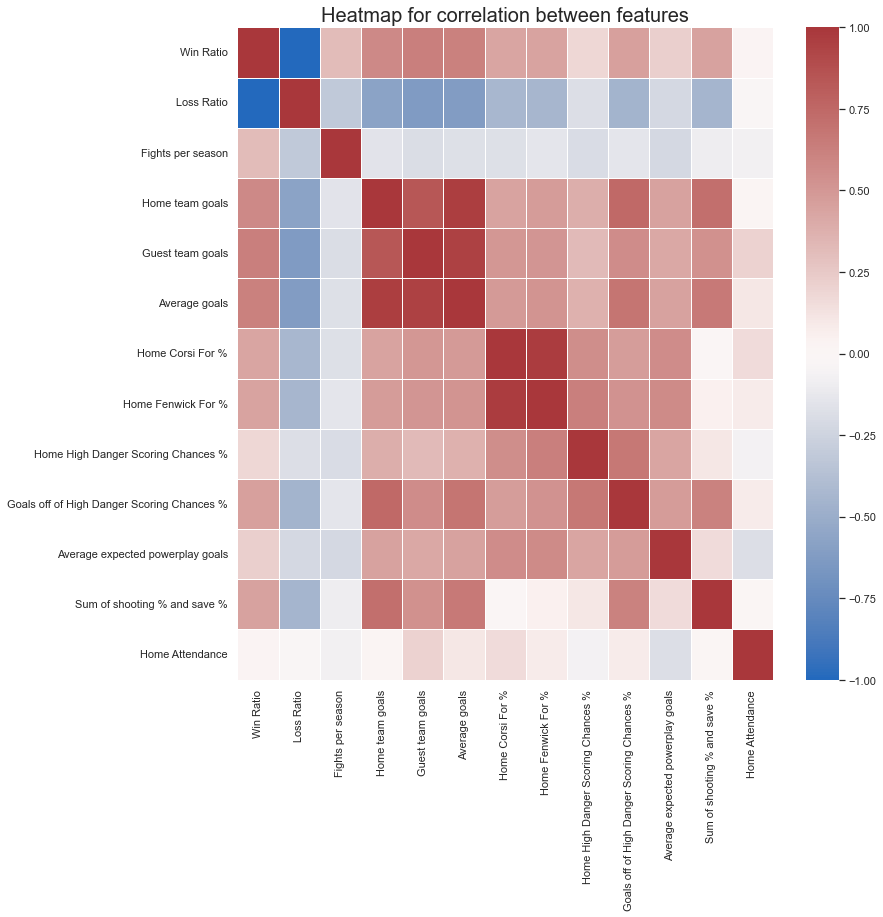

In [25]:
fig = sns.heatmap(merged.corr(), linewidths=1, cmap="vlag")
fig.axes.set_title('Heatmap for correlation between features',fontsize=20)
sns.set(rc = {'figure.figsize':(12,12)})
plt.show()

In [26]:
features = list(merged.corr().loc['Fights per season', :].index)
del features[2]
correlation = list(merged.corr().loc['Fights per season', :].values)
del correlation[2]

#### Bar chart displaying correlation of fights and game outcomes

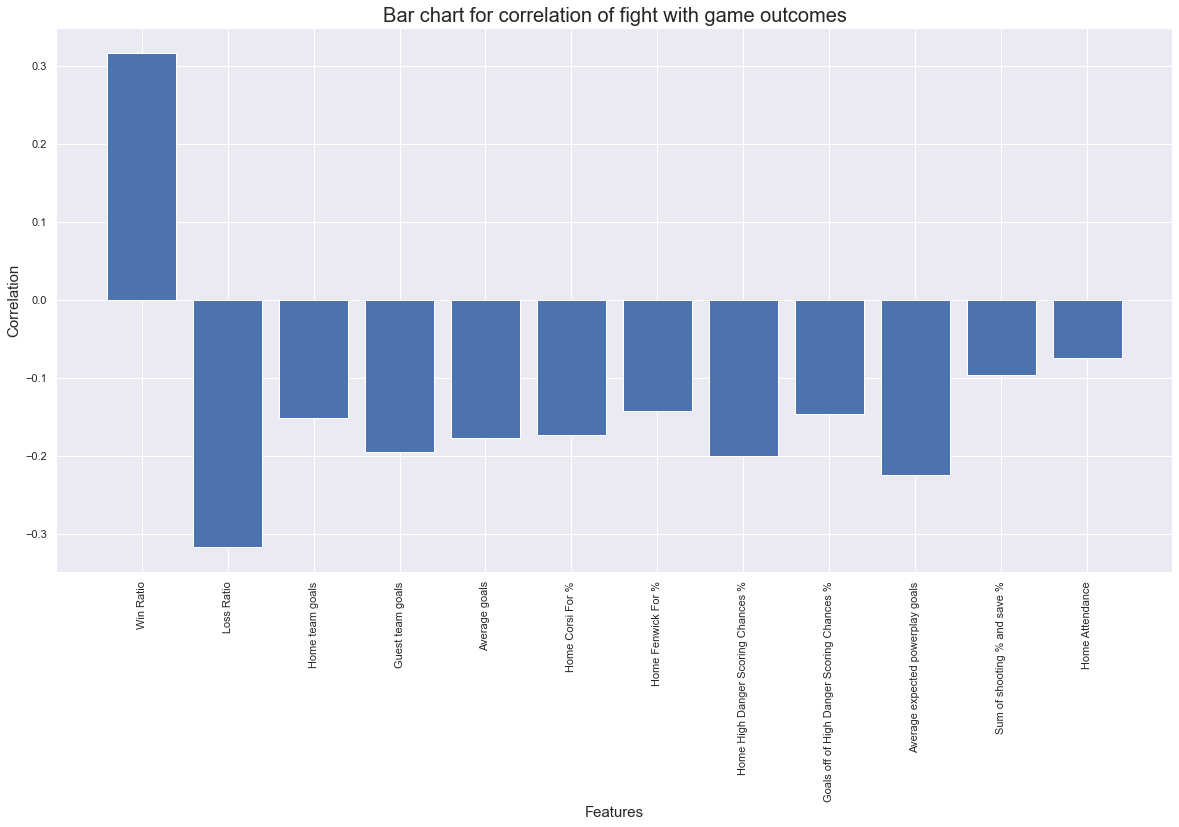

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x=features, height=correlation)
plt.xticks(rotation = 90)
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Correlation', fontsize=15)
ax.set_title('Bar chart for correlation of fight with game outcomes', fontsize=20)
plt.show()

#### Grouped the teams by divisons and conferences and obtained correlation between features

In [28]:
abbr = [list(team_info.teams[idx].values())[4] for idx in range (team_info.shape[0])]
conference = [list((list(team_info.teams[idx].values())[9]).values())[1] for idx in range (team_info.shape[0])]
divison = [list(list(team_info.teams[idx].values())[8].values())[1] for idx in range (team_info.shape[0])]
abbr = [list(team_info.teams[idx].values())[4] for idx in range (team_info.shape[0])]

In [29]:
merged.set_index(['index'], inplace= True)

In [30]:
for idx, val in enumerate(abbr):
    for i in range(merged.shape[0]):
        if val == merged.index[i]:
            merged.loc[val,'conference'] = conference[i]
            merged.loc[val,'divison'] = divison[i]

#### Heatmap displaying correlation between features when teams are grouped by divison

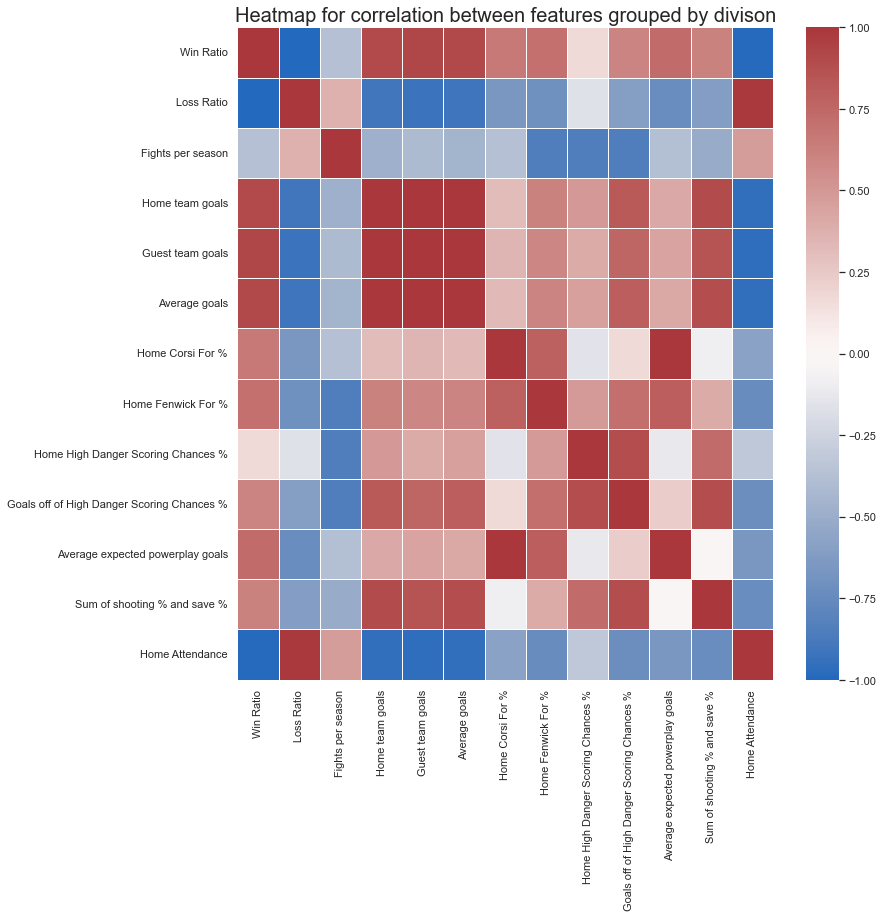

In [31]:
merged_div = merged.groupby('divison').mean()
fig = sns.heatmap(merged_div.corr(), linewidths=1, cmap="vlag")
fig.axes.set_title('Heatmap for correlation between features grouped by divison',fontsize=20)
sns.set(rc = {'figure.figsize':(12,12)})
plt.show()

#### Bar chart displaying correlation between features when teams are grouped by divison

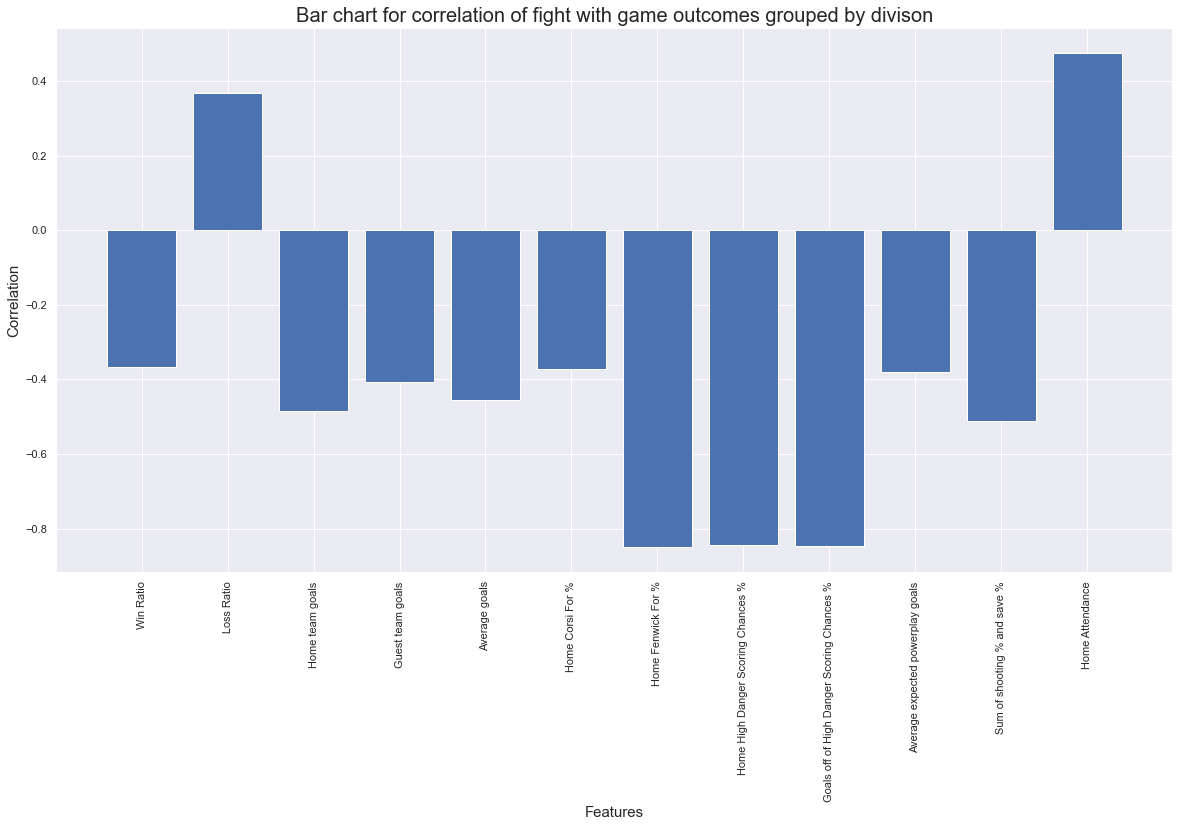

In [32]:
features = list(merged_div.corr().loc['Fights per season', :].index)
del features[2]
correlation = list(merged_div.corr().loc['Fights per season', :].values)
del correlation[2]

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x=features, height=correlation)
plt.xticks(rotation = 90)
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Correlation', fontsize=15)
ax.set_title('Bar chart for correlation of fight with game outcomes grouped by divison', fontsize=20)
plt.show()

In [33]:
def team_correlation(team, message1, message2):
    
    '''
        This function is used to plot the correlation between fights and statistical game outcome for a
        particular team.
        
        :param team: Name of team for which we will find correlation
        :param message1: Title to be displayed on the heatmap
        :param message2: Title to be displayed on the bar chart
    '''

    df = match[(match['home_team'] == team) | (match['away_team'] == team)]
    df.reset_index(inplace=True, drop=True)
    
    win = []
    loss = []
    
    for val in range(df.shape[0]):
        if df.loc[val, 'Host_won'] == 1:
            win.append(df.loc[val, 'home_team'])
            loss.append(df.loc[val, 'away_team'])
        else:
            win.append(df.loc[val, 'away_team'])
            loss.append(df.loc[val, 'home_team'])
            
    win_ratio = pd.Series(win).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())
    loss_ratio = pd.Series(loss).value_counts() / (pd.Series(win).value_counts() + pd.Series(loss).value_counts())
    
    final_df = pd.DataFrame()
    
    final_df['win_ratio'] = win_ratio
    final_df['loss_ratio'] = loss_ratio
    
    fights_per_season = []
    
    for val in sorted(total_fights.keys()):
        final_df.loc[val, 'fights_per_season'] = total_fights[val]
        
    final_df.corr(method='spearman')
    
    home_goals = match.groupby(['home_team'])['home_score'].sum()
    away_goals = match.groupby(['away_team'])['away_score'].sum()
    
    final_df['home_goals'] = home_goals / match['home_team'].value_counts().sort_index()
    final_df['away_goals'] = away_goals / match['away_team'].value_counts().sort_index()
    
    final_df['average_goals'] = (home_goals + away_goals) / (match['home_team'].value_counts().sort_index() \
                                                             + match['away_team'].value_counts().sort_index())
    
    for val in match.columns[6::2]:
        final_df[val] = match.groupby(['home_team'])[val].mean()
        
    rename_features(final_df)
    
    print('Team name:', mapping[team])
    
    fig = sns.heatmap(final_df.corr(), linewidths=1, cmap="vlag")
    fig.axes.set_title(message1,fontsize=20)
    sns.set(rc = {'figure.figsize':(12,12)})
    plt.show()
    
    features = list(final_df.corr().loc['Fights per season', :].index)
    del features[2]
    correlation = list(final_df.corr().loc['Fights per season', :].values)
    del correlation[2]

    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(x=features, height=correlation)
    plt.xticks(rotation = 90)
    ax.set_xlabel('Features', fontsize=15)
    ax.set_ylabel('Correlation', fontsize=15)
    ax.set_title(message2, fontsize=20)
    plt.show()

#### Heatmap and Bar chart for team that had maximum fights per season

Team name: Anaheim Ducks


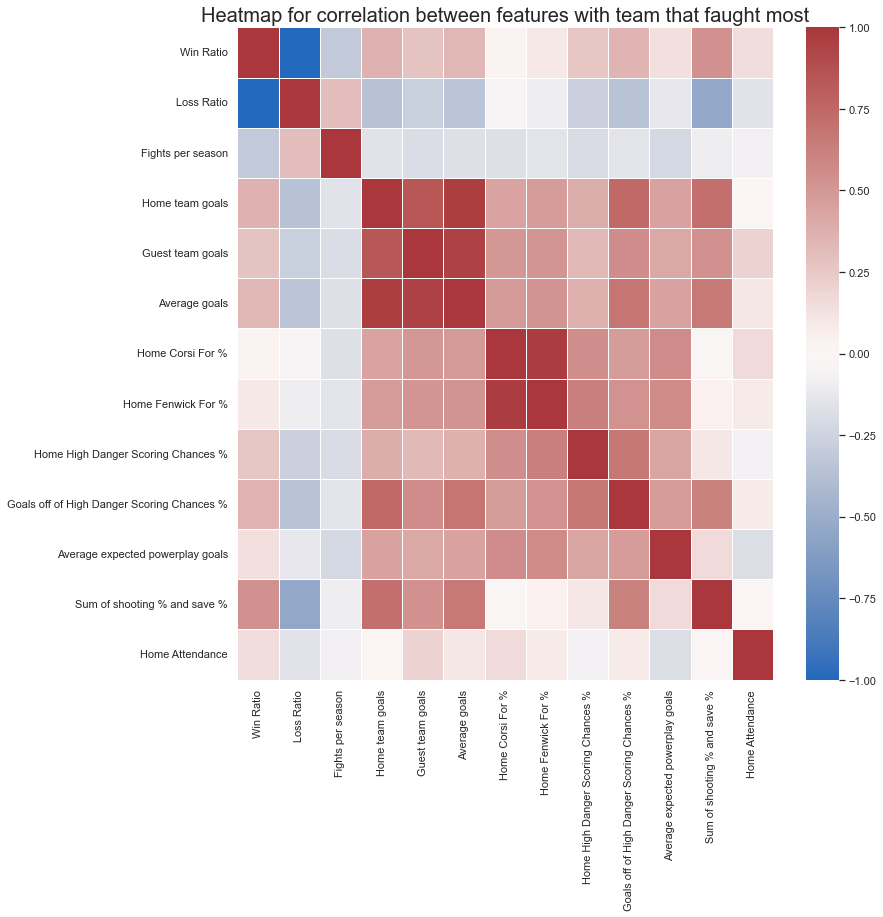

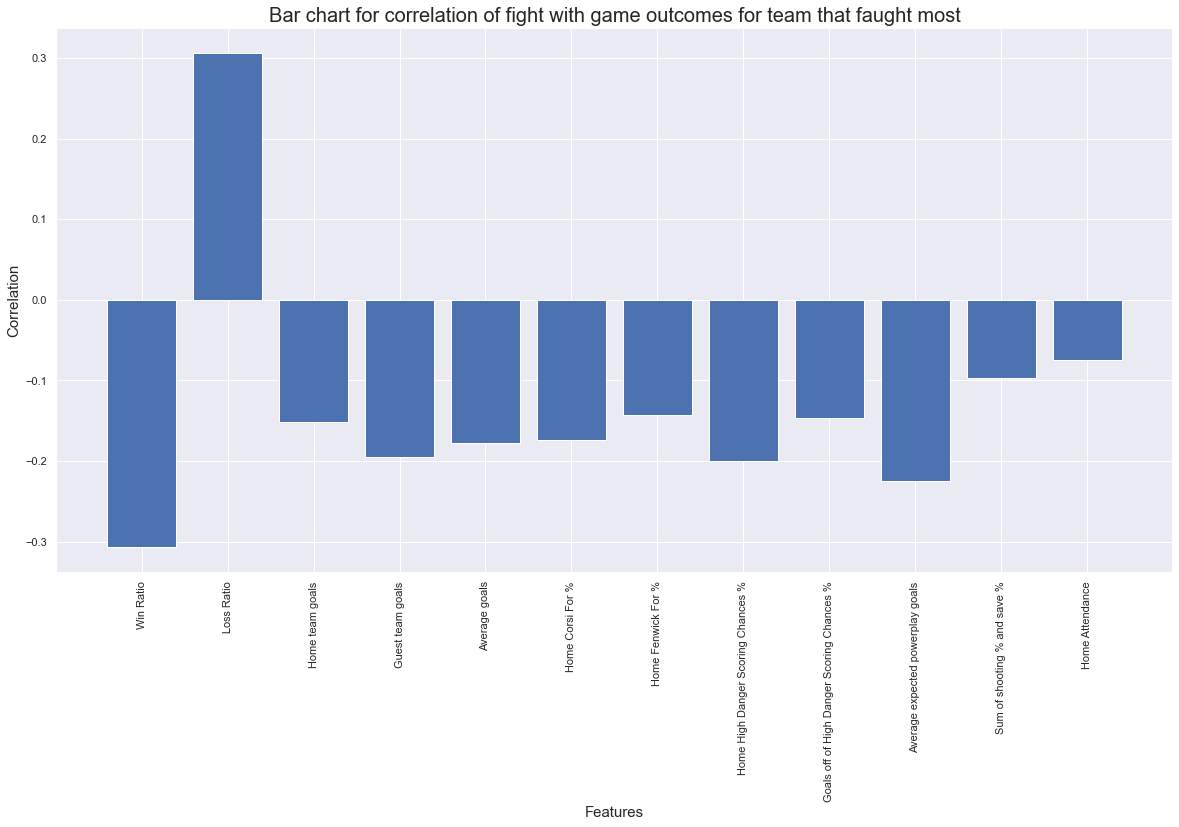

In [34]:
team_correlation(max_fight_team, 'Heatmap for correlation between features with team that faught most', \
                'Bar chart for correlation of fight with game outcomes for team that faught most')

#### Heatmap and Bar chart for team that had least fights per season

Team name: Vegas Golden Knights


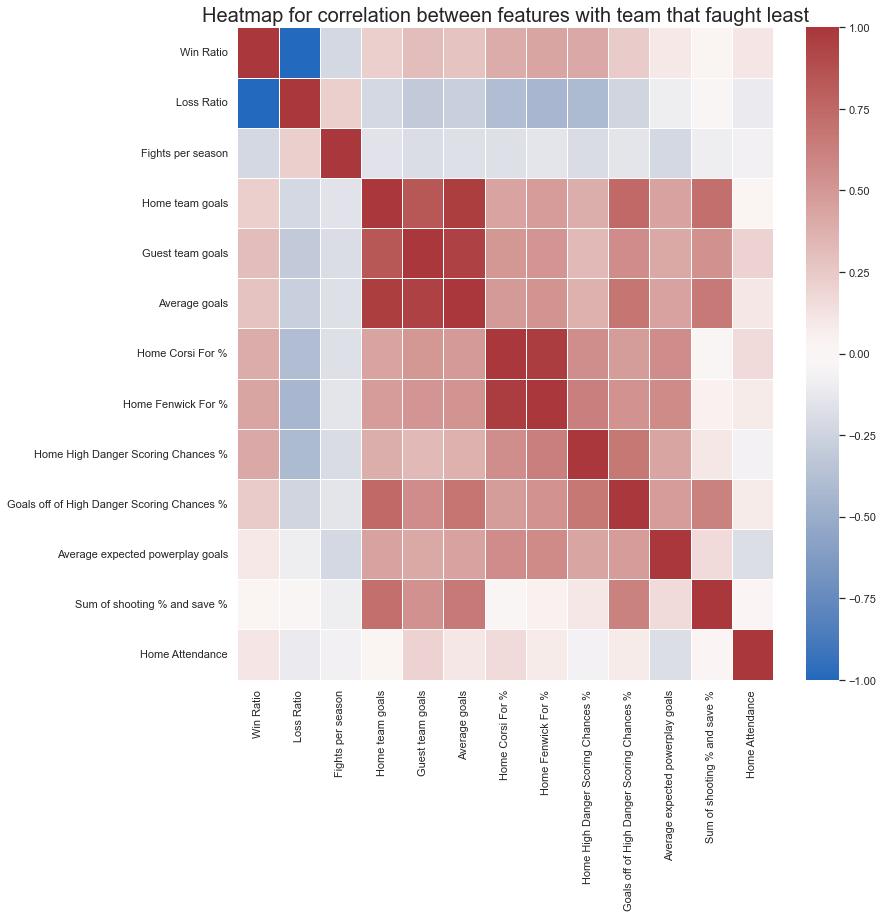

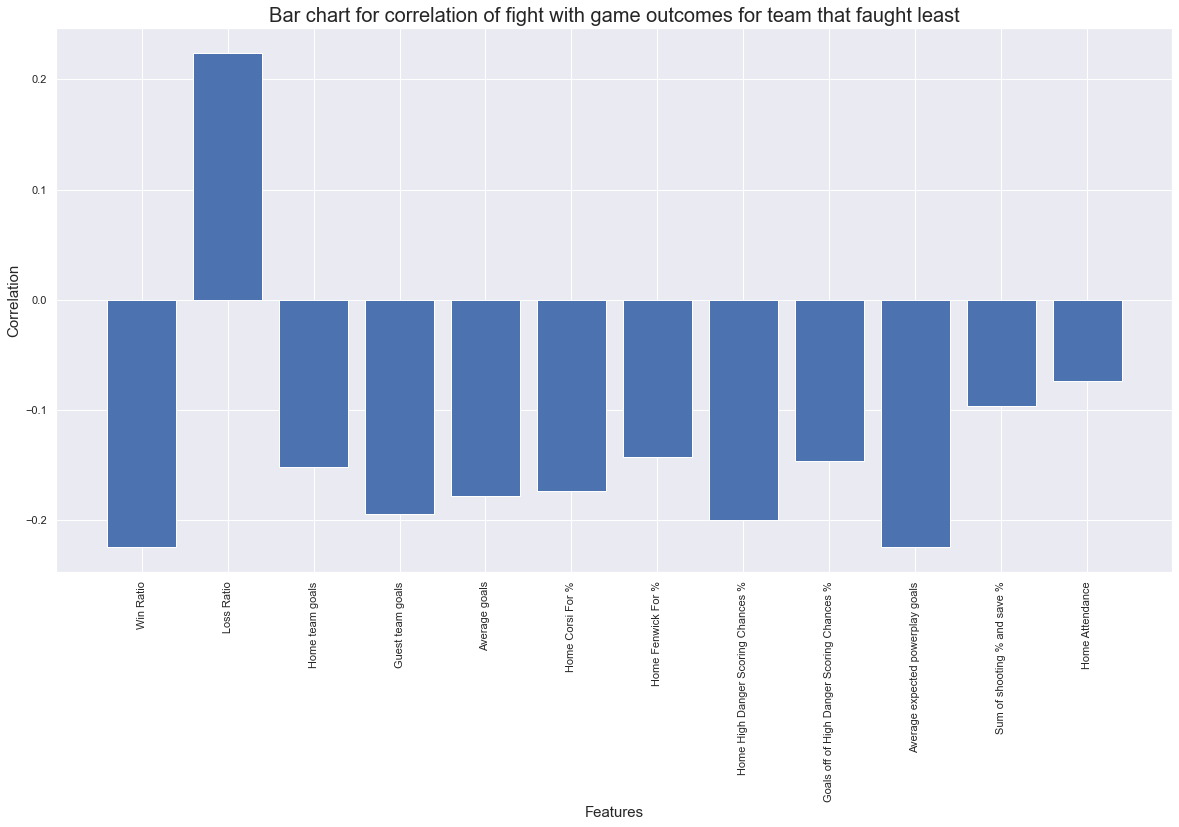

In [35]:
team_correlation(min_fight_team, 'Heatmap for correlation between features with team that faught least', \
                'Bar chart for correlation of fight with game outcomes for team that faught least')

In [36]:
match['date'] = pd.to_datetime(match['date'])

#### Feature generation in match dataframe from both fight and match dataframe. 

In [37]:
def categorise(row):
    
    '''
        This function is used to compare the date, home team and away team of fight dataframe with match
        dataframe and returns 1 if samples are matched
        
        :param row: sample from match dataframe
        :return 1: if the samples are matched, 1 is returned
    '''
    
    for idx in range(fight.shape[0]):
        if ((fight.loc[idx, 'date_of_fight'] == row['date']) and \
            (fight.loc[idx, 'player1_team'] == row['home_team']) and \
            (fight.loc[idx, 'player2_team'] == row['away_team'])):
            return 1

match['fight'] = match.apply(lambda row: categorise(row), axis=1)
match['fight'] = match['fight'].fillna(0)

In [38]:
def categorise(row):
    if row['home_score'] > row['away_score']:
        return 1
    else:
        return 0

match['home_team_won'] = match.apply(lambda row: categorise(row), axis=1)

In [39]:
def categorise(row):
    if row['home_score'] < row['away_score']:
        return 1
    else:
        return 0

match['away_team_won'] = match.apply(lambda row: categorise(row), axis=1)

#### Select all the samples from match dataframe where a team faught

In [40]:
fight = match[match['fight'] == 1]
fight.reset_index(inplace= True, drop= True)

In [41]:
features = ['fight_1', 'fight_2', 'fight','home_score_2', 'home_score_1', \
            'home_score', 'home_CF%_2', 'home_CF%_1', 'home_CF%','home_FF%_2', \
            'home_FF%_1', 'home_FF%', 'home_HDCF%_2', 'home_HDCF%_1', 'home_HDCF%', \
            'home_HDGF%_2', 'home_HDGF%_1', 'home_HDGF%','home_PDO_2', 'home_PDO_1', \
            'home_PDO', 'home_Attendance_2', 'home_Attendance_1', \
            'home_Attendance', 'home_team_won_2', 'home_team_won_1', 'home_team_won', \
            'home_score_2', 'home_score_1', 'home_score', \
            'home_xGF_pp_2', 'home_xGF_pp_1', 'home_xGF_pp', 'home_PDO_2', 'home_PDO_1', \
            'home_PDO']

In [42]:
def rename_features(df):
    
    '''
        This function is used to rename the features of dataframe
        
        :param df: Name of dataframe whose features are to be renamed
    '''
    
    df.rename(columns={'fight_1': 'Fights in current match', \
                       'home_score_2': 'Goals by home team in current match', \
                       'home_score_1': 'Goals by home team in next match', \
                       'home_score': 'Goals by home team in next to next match', \
                       'home_CF%_2': 'Home Corsi For % in current match', \
                       'home_CF%_1': 'Home Corsi For % in next match', \
                       'home_CF%': 'Home Corsi For % in next to next match', \
                       'home_FF%_2': 'Home Fenwick For % in current match', \
                       'home_FF%_1': 'Home Fenwick For % in next match', \
                       'home_FF%': 'Home Fenwick For % in next to next match', \
                       'home_HDCF%_2': 'Home High Danger Scoring Chances % in current match', \
                       'home_HDCF%_1': 'Home High Danger Scoring Chances % in next match', \
                       'home_HDCF%': 'Home High Danger Scoring Chances % in next to next match', \
                       'home_Attendance_2': 'Home attendance in current match', \
                       'home_Attendance_1': 'Home attendance in next match', \
                       'home_Attendance': 'Home attendance in next to next match', \
                       'home_team_won_2': 'Home team won in current match', \
                       'home_team_won_1': 'Home team won in next match', \
                       'home_team_won': 'Home team won in next to next match'}, inplace= True)

In [43]:
def upcoming_match_correlation(team_a, team_b):
    
    '''
        This function is used to plot heatmap and bar chart of correlation between fight and game 
        outcome in successive two matches
        
        :param team_a: name of home team
        :param team_b: name of guest team        
    '''
    fight_index = set(fight[(fight['home_team'] == team_a) | (fight['away_team'] == team_b)].index)
    match_index = match[(match['home_team'] == team_a) | (match['away_team'] == team_b)].index

    df = pd.DataFrame()
    for idx in range(len(match_index)):
        if match_index[idx] in fight_index:
            s1 = match.iloc[match_index[idx], :]
            s1 = s1.add_suffix('_1')

            if idx+1 < len(match_index):
                s2 = match.iloc[match_index[idx+1], :]
                s2 = s2.add_suffix('_2')
                s1 = pd.concat([s1,s2])

            if idx+2 < len(match_index):
                s3 = match.iloc[match_index[idx+2], :]
                s1 = pd.concat([s1,s3])
            df = df.append(s1, ignore_index=True)
    df = df[features]
    df = df[['fight_1', 'home_score_2', 'home_score_1', \
             'home_score', 'home_CF%_2', 'home_CF%_1', 'home_CF%', 'home_FF%_2', \
             'home_FF%_1', 'home_FF%', 'home_HDCF%_2', 'home_HDCF%_1', 'home_HDCF%', \
             'home_Attendance_2', 'home_Attendance_1', 'home_Attendance', \
             'home_team_won_2', 'home_team_won_1', 'home_team_won']]
    
    rename_features(df)
    print('Home team:', team_a)
    print('Guest team:', team_b)
    sns.set(font_scale = 1.2)
    fig = sns.heatmap(df.corr(), linewidths=1, cmap = 'vlag')
    fig.axes.set_title('Heatmap for correlation between fight and game outcome in successive two matches', \
                       fontsize=15)
    sns.set(rc = {'figure.figsize':(10,10)})
    
    feature = df.corr().loc[:, 'Fights in current match'].index[1:]
    values = list(df.corr().loc[:, 'Fights in current match'].values[1:])
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(x=feature, height=values)
    plt.xticks(rotation = 90)
    ax.set_xlabel('Features', fontsize=20)
    ax.set_ylabel('Correlation', fontsize=20)
    ax.set_title('Bar chart for correlation between fight and game outcome in successive two matches', \
                 fontsize=20)
    plt.rcParams.update({'font.size': 25})
    plt.show()

#### Plot heatmap and bar chart of correlation between fight and game outcome in successive two matches

Home team: TOR
Guest team: VAN


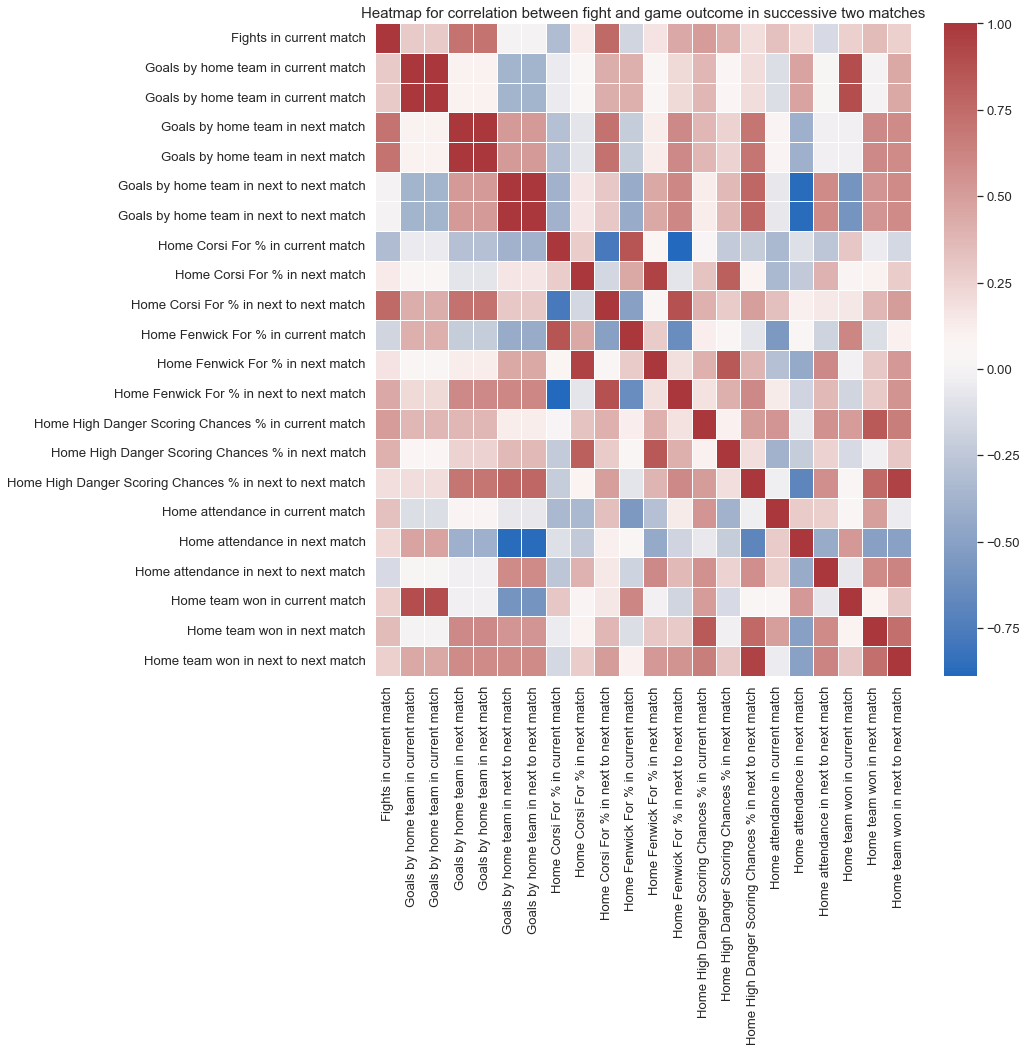

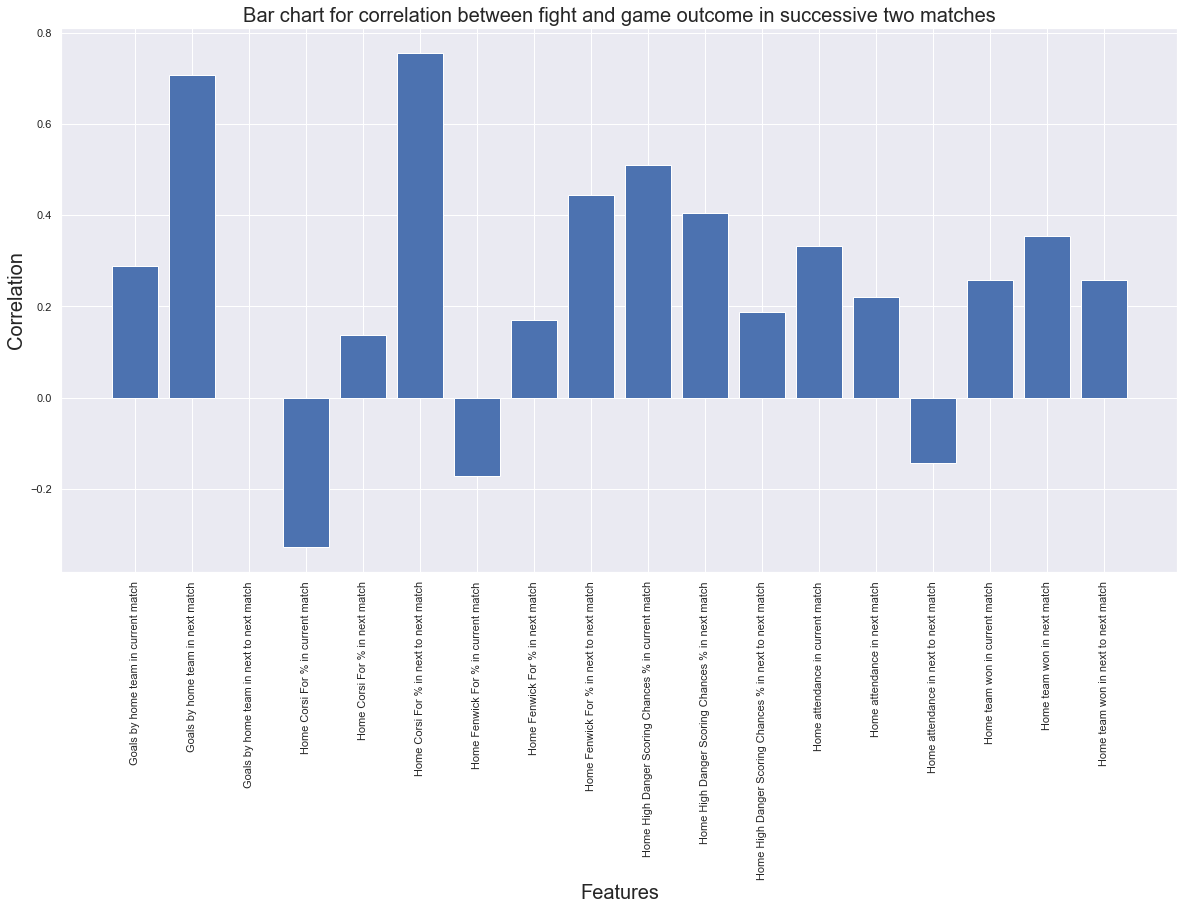

In [44]:
'''
    We need to provide name of two teams for which we would like to obtain correlation. The first argument which
    we specify while passing to the function will be the name of home team and second argument will be name of
    guest team.
'''

upcoming_match_correlation('TOR', 'VAN')